<a href="https://colab.research.google.com/github/michaelbarkasi/computational_neuroscience/blob/main/neural_decoding_template_faux_data_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Decoding (Logistic Regression) Example

Michael Barkasi 2023

This CoLab first generates some faux sample fMRI data of somatomotor cortex during unilateral hand, unilateral foot, and tongue movements, then uses a GLM to decode the task from the data (logistic regression). The decoder was originally written to be used with the curated [Human Connectome Project data released by Neuromatch Academy](https://compneuro.neuromatch.io/projects/fMRI/README.html). It works pretty well with real data, but the HCP data has limitations on sharing, so for this demo I just use simulated data. The simulated data is at the region level (Brodmann regions, specifically).

It turns out that simulating fMRI data in any way that's even sort of realistic without being trivially easy -- or impossibly hard -- to decode is tricky. My simulated data has some biologically realistic features, but is unrealistic in many ways as well.

Although the data used here is all simulated, the region names are based on the atlas by [Glasser et al. 2016](https://www.nature.com/articles/nature18933), described [in the paper's supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf). Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

A few chunks of code are borrowed from the [2023 NMA material](https://compneuro.neuromatch.io/tutorials/intro.html), but mostly everything here is mine. The code for the band-pass filter was suggested to me by ChatGPT. I double checked it and tweaked it. I used ChatGPT for other suggestions here or there, but nothing else substantive.

[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/) // [BSD (3-Clause) License](https://opensource.org/licenses/BSD-3-Clause)

In [ ]:
# @title CoLab Reset
# Want to reset loaded code?
%reset -f

In [ ]:
# @title Helper Functions

def HRF(t,A):
  '''
  Hemodynamic Response Function (cannonical double gamma)
  t = time
  A = reponse amplitude
  from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3318970/#FD7
  '''
  a1 = 6
  a2 = 16
  b1 = 1
  b2 = 1
  c = 1/6
  term1 = ((t**(a1-1))*(b1**a1)*(np.exp(-b1*t)))/scipy.special.gamma(a1)
  term2 = ((t**(a2-1))*(b2**a2)*(np.exp(-b2*t)))/scipy.special.gamma(a2)
  output = A * (term1 - c*term2)
  return output

def convolve_HRF(time_series,conv_window,amplitude):
  '''
  Convolve time_series with HRF (hemodynamic response function)
  time_series = time series to be convolved
  conv_window = window for convolving
  amplitude = amplitude of HRF
  '''
  conv_time_series = np.zeros(len(time_series))
  for series_time in np.arange(len(time_series)):
      conv_time_series[series_time] = np.sum(time_series[series_time-np.arange(conv_window)] * HRF(np.arange(conv_window),amplitude))

  return conv_time_series

def stim_frames(data,subj_,run_,cond):
  cond_ = 0
  if type(cond) == str:
    cond_ = np.where(tasks == cond)[0]
  else:
    cond_ = cond
  time_series_ = data[:,cond_,subj_,run_]
  return np.where(time_series_ == 1)[0]

def region_index(region__):
  reg_ = 0
  if type(region__) == str:
    keys_list = list(somatomotor_regions.keys())
    reg_ = keys_list.index(region__)
  else:
    reg_ = region__
  return reg_

def band_pass(x,sampling_frequency=1.389,lower_cutoff_frequency=0.008,upper_cutoff_frequency=0.09):

  '''
  for the default values, 1.389 = 1 sec / 0.72 sec sample interval,
  and 0.008 / 0.09 are standard cutoffs for fMRI data.
  '''

  # Perform Fourier transform
  x_freq = np.fft.fft(x)

  # Apply band-pass filter in frequency domain
  n = len(x)
  frequencies = np.fft.fftfreq(n, d=1/sampling_frequency)
  # x_freq[np.abs(frequencies) > cutoff_frequency] = 0 # if using just as a low-pass
  x_freq[np.logical_or(frequencies < lower_cutoff_frequency, frequencies > upper_cutoff_frequency)] = 0

  # Perform inverse Fourier transform
  x_filtered = np.fft.ifft(x_freq).real

  return x_filtered

def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """

  y_pred = model.predict(X)
  accuracy = (y == y_pred).mean()
  ones = np.where(y)[0]
  pos_accuracy = (y[ones] == y_pred[ones]).mean()
  zeros = np.where(y==0)[0]
  neg_accuracy = (y[zeros] == y_pred[zeros]).mean()

  return accuracy,pos_accuracy,neg_accuracy

# Simulate Data

The first step is, of course, to simulate some data. My aim here was to:

1. Inject information into the simulated BOLD activity level about what simulated task was happening, without
2. making it trivially easy to decode.

There are a few layers to the simulated BOLD activity:

1. A base level of noise and upward drift (often seen in real fMRI data).
2. A level of random noise in the form of what I call "random-walk mind wandering". Basically, Basically, suppose the subject isn't really focused and is doing other things (thinking, moving) in ways that cause the BOLD level to shift in the form of a random walk.
3. The task-depenent BOLD response itself.

The last of these is, of course, what the logistic regression decoder is trying to pull out of the data.
The exact method here has several layers, but the gist is a two step process:

1. Pick, for each region, a response amplitude for each task. The larger the magnetude of this response, the more the region becomes a "detector" for that task.
2. For each subject, randomly jitter this response amplitude.

The second step is needed, otherwise the detector sits at 100% accuracy under all but the most extreme noise conditions.

Additionally, I've set the simulation to (loosely) enforce three other constraints:

1. A region should be anticorrelated with its counterpart in the opposite hemisphere.
2. Regions within the same hemisphere shoul be correlated.
3. Reponse amplitude on the same side is negative, e.g. right hemisphere regions generally respond positively to left-side movements.



Simulating task and fMRI time-series data for somatomotor Brodmann regions.


Simulation parameters:


Number of subjects: 20
Number of regions: 38
Number of tasks: 5
Number of runs: 2
Tasks repeats per run: 2


Task length: 17
Intertask cue length: 3
Run length: 200


Tasks: ['lh' 'lf' 'rh' 'rf' 't']


For each subject, on each run, we get a time series of zeros and ones:




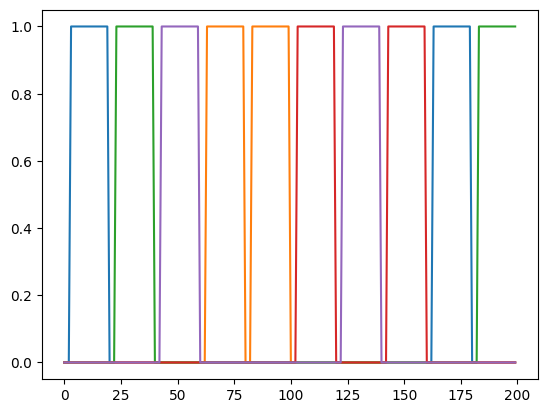



In the above plot, each color represents one of the different tasks, 1 if it's being done, 0 otherwise.
This plot is just one run for one subject, but a similar one is generated for each run of each subject.
The task order is randomized between runs and subjects.


Simulating BOLD data.


Note: There are _many_ parameters involved in setting the kinds and levels of noise,
as well as the degree of correlation (and anti-correlation) between region regions.
I explain above the general principles I used to set these parameters, but the biggest
was just setting them so that the decoder returned a reasonable prediction accuracy (about 90%),
and didn't either sit and chance (50%) or stay pegged at 100%.


These settings do look like reasonable BOLD signals for brain regions -- the BOLD signal roughly
resembles the HCP data. Feel free to play with them and see what you get.


Step 1: Generate baseline BOLD noise and drift for each subject.


Mean drift slope: 0.05
Subject drift variation (SD

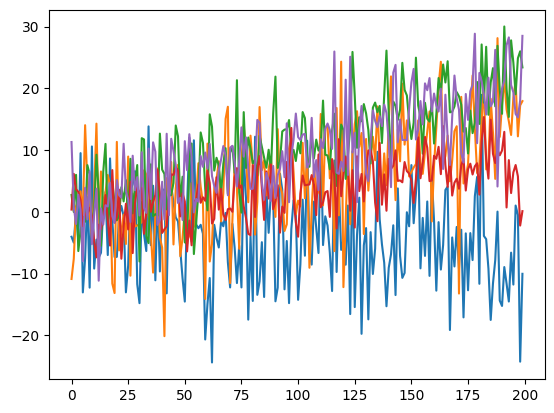



We can zoom out to see it on the scale of the end activity we'll simulate:




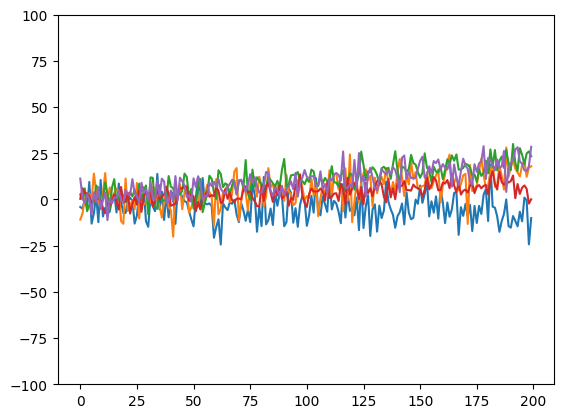



Step 2: Generate random-walk mind-wandering for each subject.


Mean distraction: 2.0
Distraction variation: 1.0


Here is the random-walk mind-wandering added to the baseline noise and drift (in one region,
 the same as before) for the same five subjects, from the same run:




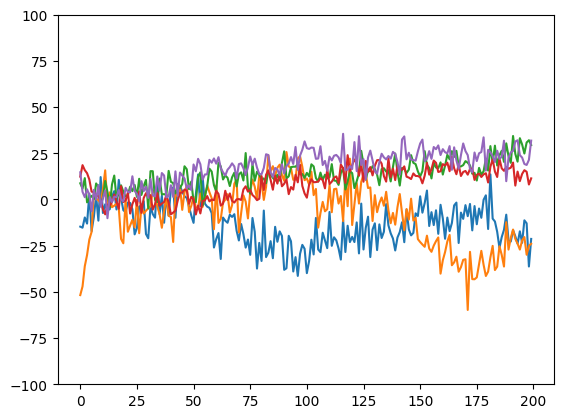



Step 3: Generate activity-driven BOLD signal for each subject.


Constructing HRF convolution amplitude array with bilateral anticorrelation and lateral correlation.


Mean convolution amplitude magnetude: 25.0
Size of variation in amplitude correlation (intrahemisphere): 20.0
Mean anticorrelation noise (interhemisphere): 0
Anticorrelation noise variation (interhemisphere): 3
Convolution amplitude noise: 25
Convolution amplitude jitter: 0.3
Receptive field destabilization factor: 0.9


Setting activity-driven BOLD signal for each subject.


Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%


Example plots of some of the data we just generated:


Activity-driven BOLD signal from one run, in one region (one task, one subject):




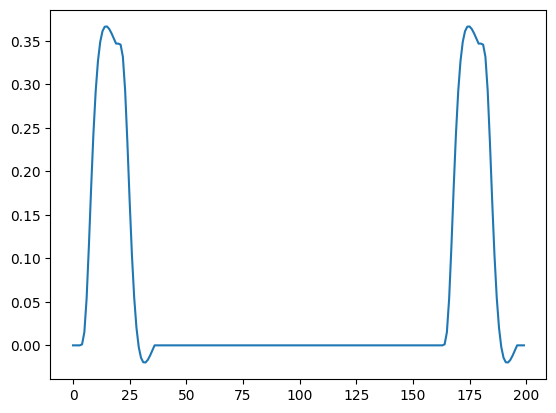



Activity-driven BOLD signal in 3 right regions (same subject) during one right task:




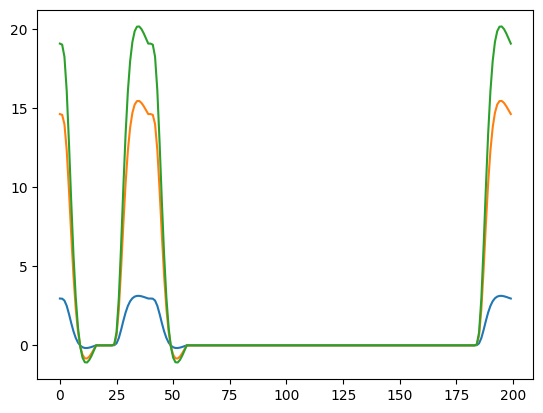



Activity-driven BOLD signal in a left and right region (same subject) during that same right task:




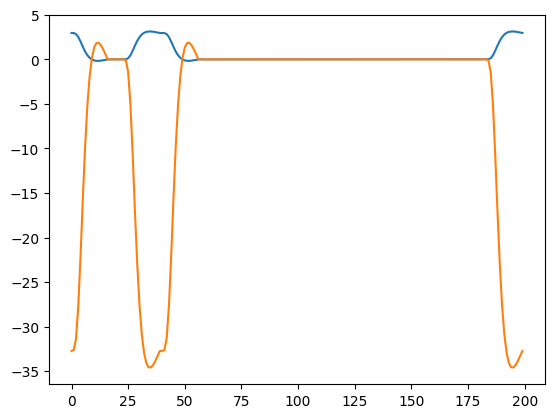



BOLD signal for three different subjects, same region and same run:




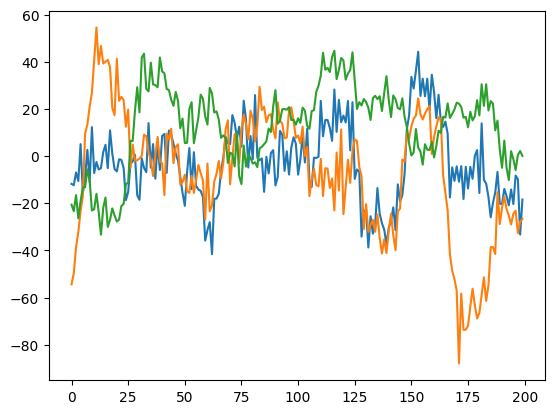



Mean BOLD signal for right-side network in three different subjects, same run:




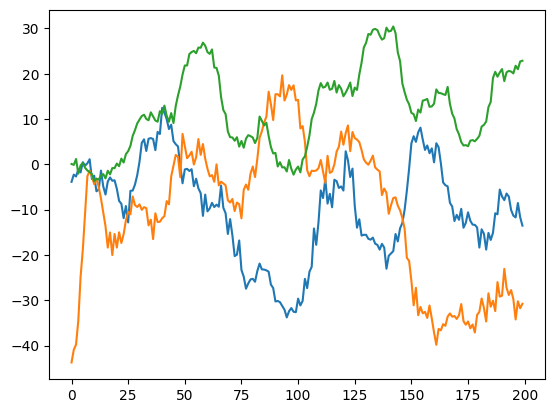

In [ ]:
# @title Simulate data (code)

# Packages
#import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt

# To ensure the same data is generated each time (assuming _nothing_ else is changed!).
np.random.seed(100)

print("\n")
print("Simulating task and fMRI time-series data for somatomotor Brodmann regions.")

# Dictionary of somatomotor regions (mostly for visualization with atlas)
# The HCP data from NMA also included 'L_RI': 283, but I've moved so there's symmatry.
somatomotor_regions = {
    'R_4': 7,'R_3b': 8,'R_5m': 35,'R_5L': 38,'R_24dd': 39,'R_24dv': 40,'R_7AL': 41,'R_7PC': 46,'R_1': 50,
    'R_2': 51,'R_3a': 52,'R_6d': 53,'R_6mp': 54,'R_6v': 55,'R_OP4': 99,'R_OP1': 100,'R_OP2-3': 101,'R_FOP2': 114,'R_Ig': 167,
    'L_4': 187,'L_3b': 188,'L_5m': 215,'L_5L': 218,'L_24dd': 219,'L_24dv': 220,'L_7AL': 221,'L_7PC': 226,
    'L_1': 230,'L_2': 231,'L_3a': 232,'L_6d': 233,'L_6mp': 234,'L_6v': 235,'L_OP4': 279,'L_OP1': 280,'L_OP2-3': 281,
    'L_FOP2': 294,'L_Ig': 347
}

# Simulation parameters for faux data
n_subjects = 20
n_regions = len(somatomotor_regions)
tasks = np.array(['lh','lf','rh','rf','t'])
n_tasks = len(tasks)
task_length = 17
cue_length = 3
task_repeats_per_run = 2
run_length = (n_tasks*task_repeats_per_run)*(task_length+cue_length)
n_runs = 2
time_step_size = 0.72 # in seconds

print("\n")
print("Simulation parameters:")

print("\n")
print(f"Number of subjects: {n_subjects}")
print(f"Number of regions: {n_regions}")
print(f"Number of tasks: {n_tasks}")
print(f"Number of runs: {n_runs}")
print(f"Tasks repeats per run: {task_repeats_per_run}")

print("\n")
print(f"Task length: {task_length}")
print(f"Intertask cue length: {cue_length}")
print(f"Run length: {run_length}")

print("\n")
print(f"Tasks: {tasks}")

print("\n")
# Simulate task data
task_data = np.zeros((run_length,n_tasks,n_subjects,n_runs))
for run in np.arange(n_runs):
  for sub in np.arange(n_subjects):
    # Pick a random task order for the subject
    sub_task_order = []
    for task_repeat in np.arange(task_repeats_per_run):
      sub_task_order = sub_task_order + list(range(n_tasks))
    random.shuffle(sub_task_order)
    # Identify task at each step in time series
    task_at_time = []
    for task in sub_task_order:
      for cue_step in np.arange(cue_length):
        task_at_time = task_at_time + [-1]
      for task_step in np.arange(task_length):
        task_at_time = task_at_time + [task]
    if len(task_at_time) != run_length:
      print("Warning! Problem building task_at_time.") # Sanity check
    # Simulate task data for subject
    for time_step in np.arange(run_length):
      for task in np.arange(n_tasks):
        if task == task_at_time[time_step]:
          # Array is all zeros; a 1 indicates that task is happening
          task_data[time_step,task,sub,run] = 1

# Check and demonstrate what we've done:
print("For each subject, on each run, we get a time series of zeros and ones:")

print("\n")
plt.plot(task_data[:,0,0,0])
plt.plot(task_data[:,1,0,0])
plt.plot(task_data[:,2,0,0])
plt.plot(task_data[:,3,0,0])
plt.plot(task_data[:,4,0,0])
plt.show()

print("\n")
print("In the above plot, each color represents one of the different tasks, 1 if it's being done, 0 otherwise.")
print("This plot is just one run for one subject, but a similar one is generated for each run of each subject.")
print("The task order is randomized between runs and subjects.")

print("\n")
print("Simulating BOLD data.")

print("\n")
print("Note: There are _many_ parameters involved in setting the kinds and levels of noise,")
print("as well as the degree of correlation (and anti-correlation) between region regions.")
print("I explain above the general principles I used to set these parameters, but the biggest")
print("was just setting them so that the decoder returned a reasonable prediction accuracy (about 90%),")
print("and didn't either sit and chance (50%) or stay pegged at 100%.")

print("\n")
print("These settings do look like reasonable BOLD signals for brain regions -- the BOLD signal roughly")
print("resembles the HCP data. Feel free to play with them and see what you get.")

print("\n")
print("Step 1: Generate baseline BOLD noise and drift for each subject.")

# Parameters for BOLD noise and drift
mean_drift_slope = 0.05
subject_drift_variation = 0.05
mean_BOLD_noise = 5
subject_BOLD_noise_variation = 1.5
drift_slope = np.random.normal(mean_drift_slope,subject_drift_variation,size=n_subjects)
noise = np.abs(np.random.normal(mean_BOLD_noise,subject_BOLD_noise_variation,size=n_subjects))

print("\n")
print(f"Mean drift slope: {mean_drift_slope}")
print(f"Subject drift variation (SD): {subject_drift_variation}")
print(f"Mean BOLD baseline noise: {mean_BOLD_noise}")
print(f"Subject BOLD baseline noise variation (SD): {subject_BOLD_noise_variation}")

print("\n")
# Simulate time-series BOLD data
BOLD_data = np.zeros((run_length,n_regions,n_subjects,n_runs))
for sub in np.arange(n_subjects):
  for run in np.arange(n_runs):
    for reg in np.arange(n_regions):
      BOLD_data[:,reg,sub,run] = drift_slope[sub] * np.arange(run_length) + np.random.normal(0,noise[sub],size=run_length)

# Check and demonstrate what we've done:
print("Here is the baseline noise and drift (in one region) for five subjects, from one run:")

print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.plot(BOLD_data[:,0,3,0])
plt.plot(BOLD_data[:,0,4,0])
plt.show()

print("\n")
print("We can zoom out to see it on the scale of the end activity we'll simulate:")

print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.plot(BOLD_data[:,0,3,0])
plt.plot(BOLD_data[:,0,4,0])
plt.ylim(-100, 100)
plt.show()

print("\n")
print("Step 2: Generate random-walk mind-wandering for each subject.")

conv_window = int(task_length * 1) # window size for HRF convolution

# Parameters for Random-Walk Mind-Wandering
mean_distraction = 2.0
distraction_variation = 1.0
distraction = np.abs(np.random.normal(mean_distraction,distraction_variation,size=n_subjects))

print("\n")
print(f"Mean distraction: {mean_distraction}")
print(f"Distraction variation: {distraction_variation}")

for sub in np.arange(n_subjects):
  for run in np.arange(n_runs):
    raw_RWMW = np.zeros(run_length)
    for time_step in np.arange(run_length)[1:]:
      raw_RWMW[time_step] = raw_RWMW[time_step-1] + np.random.normal(0,distraction[sub])
    # Convolve with HRF (hemodynamic response function)
    conv_RWMW = convolve_HRF(raw_RWMW,conv_window,1)
    for reg in np.arange(n_regions):
      BOLD_data[:,reg,sub,run] += conv_RWMW

# Check and demonstrate what we've done:
print("\n")
print("Here is the random-walk mind-wandering added to the baseline noise and drift (in one region,\n the same as before) for the same five subjects, from the same run:")

print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.plot(BOLD_data[:,0,3,0])
plt.plot(BOLD_data[:,0,4,0])
plt.ylim(-100, 100)
plt.show()

print("\n")
print("Step 3: Generate activity-driven BOLD signal for each subject.")

print("\n")
print("Constructing HRF convolution amplitude array with bilateral anticorrelation and lateral correlation.")

# Parameters for activity-driven BOLD signal
conv_amp_magnetude = 25.0
correlated_amp_variation_magnetude = 20.0
mean_anticorr_noise = 0
anticorr_noise_variation = 3

conv_amp = np.random.uniform(-conv_amp_magnetude,conv_amp_magnetude,size=(n_tasks,n_regions,n_subjects)) # Gives response of each region to each task, for each subject
conv_amp_noise = 25
conv_amp_jitter = 0.3 # a percentage between 0 and 1.

RF_destabilization = 0.9 # a percentage between 0 and 1.

print("\n")
print(f"Mean convolution amplitude magnetude: {conv_amp_magnetude}")
print(f"Size of variation in amplitude correlation (intrahemisphere): {correlated_amp_variation_magnetude}")
print(f"Mean anticorrelation noise (interhemisphere): {mean_anticorr_noise}")
print(f"Anticorrelation noise variation (interhemisphere): {anticorr_noise_variation}")

print(f"Convolution amplitude noise: {conv_amp_noise}")
print(f"Convolution amplitude jitter: {conv_amp_jitter}")
print(f"Receptive field destabilization factor: {RF_destabilization}")

# Fill convolution amplitude array
'''
We want
- unilateral regions to be correlated by laterality
- bilateral regions to be anticorrelated by laterality
- each region to have a preferred task

This should lead to:
- task-dependent functional connectivity for laterality
- but no task-dependent functional connectivity for extremities
'''
left_tasks = np.array([0,1])
right_tasks = np.array([2,3])
n_regions2 = int(n_regions / 2)
left_regions = np.arange(n_regions2,n_regions)
right_regions = np.arange(n_regions2)
# Correlate unilateral regions by laterality, ensuring at least some regions consistently have task preference across subjects
for task in left_tasks:
  # mean_amp essentially becomes the average response of a given region to a task, across the whole population
  # ... it thereby essentially gives that region a set of consistent preferences, e.g. turning it into a "lh" detector
  # ... so, it's akin to setting up a receptive field for the region
  mean_amp = np.random.uniform(-conv_amp_magnetude,conv_amp_magnetude)
  amp_variation = np.random.uniform(0.1,correlated_amp_variation_magnetude)
  for sub in np.arange(n_subjects):
    conv_amp[task,left_regions,sub] = np.random.normal(mean_amp,amp_variation,size=len(left_regions))
    # This step keeps there from being too much information in each region
    # ... we need to stabilize the receptive fields, so there isn't too much information in them.
    for task_ in left_tasks:
      conv_amp[task_,left_regions,sub] = np.random.normal(conv_amp[task_,left_regions,sub],amp_variation*RF_destabilization,size=conv_amp[task_,left_regions,sub].shape)
for task in right_tasks:
  mean_amp = np.random.uniform(-conv_amp_magnetude,conv_amp_magnetude)
  amp_variation = np.random.uniform(0.1,correlated_amp_variation_magnetude)
  for sub in np.arange(n_subjects):
    conv_amp[task,right_regions,sub] = np.random.normal(mean_amp,amp_variation,size=len(right_regions))
    # This step keeps there from being too much information in each region
    for task_ in right_tasks:
      conv_amp[task_,right_regions,sub] = np.random.normal(conv_amp[task_,right_regions,sub],amp_variation*RF_destabilization,size=conv_amp[task_,right_regions,sub].shape)
# Anticorrelate bilateral regions by laterality
for task in left_tasks:
  for reg in left_regions:
    for sub in np.arange(n_subjects):
      conv_amp[task,reg-n_regions2,sub] = -conv_amp[task,reg,sub] + np.random.normal(mean_anticorr_noise,anticorr_noise_variation)
for task in right_tasks:
  for reg in right_regions:
    for sub in np.arange(n_subjects):
      conv_amp[task,reg+n_regions2,sub] = -conv_amp[task,reg,sub] + np.random.normal(mean_anticorr_noise,anticorr_noise_variation)
# Add noise and jitter convolution amplitude array
conv_amp = np.random.normal(conv_amp,conv_amp_noise,size=conv_amp.shape)
task_jitter = np.random.choice(np.arange(n_tasks), size=int(n_tasks*conv_amp_jitter), replace=False)
region_jitter = np.random.choice(np.arange(n_regions), size=int(n_regions*conv_amp_jitter), replace=False)
subject_jitter = np.random.choice(np.arange(n_subjects), size=int(n_subjects*conv_amp_jitter), replace=False)
task_jitter_shuff = np.random.permutation(task_jitter)
region_jitter_shuff = np.random.permutation(region_jitter)
subject_jitter_shuff = np.random.permutation(subject_jitter)
conv_amp[task_jitter_shuff,:,:] = conv_amp[task_jitter,:,:]
conv_amp[:,region_jitter_shuff,:] = conv_amp[:,region_jitter,:]
conv_amp[:,:,subject_jitter_shuff] = conv_amp[:,:,subject_jitter]

print("\n")
print("Setting activity-driven BOLD signal for each subject.")

print("\n")
# Simulate time-series BOLD data
progress_interval = n_subjects // 10
AD_BOLD_data = np.zeros((run_length,n_regions,n_tasks,n_subjects,n_runs))
for i, sub in enumerate(np.arange(n_subjects)):
  percent_complete = (i + 1) / n_subjects * 100
  if (i + 1) % progress_interval == 0:
      print(f"Progress: {percent_complete:.0f}%")
  for run in np.arange(n_runs):
    for reg in np.arange(n_regions):
      for task in np.arange(n_tasks):
        # First load task time series, which is a string of 1s and 0s.
        raw_task_time_series = task_data[:,task,sub,run]
        # Convolve with HRF (hemodynamic response function)
        conv_task_time_series = convolve_HRF(raw_task_time_series,conv_window,conv_amp[task,reg,sub])
        # Save to AD_BOLD_data array
        AD_BOLD_data[:,reg,task,sub,run] = conv_task_time_series

print("\n")
print("Example plots of some of the data we just generated:")

print("\n")
print("Activity-driven BOLD signal from one run, in one region (one task, one subject):")
print("\n")
plt.plot(AD_BOLD_data[:,0,0,0,0])
plt.show()

# Activity in 3 right regions (same subject) during one right task
print("\n")
print("Activity-driven BOLD signal in 3 right regions (same subject) during one right task:")
print("\n")
plt.plot(AD_BOLD_data[:,0,2,0,0])
plt.plot(AD_BOLD_data[:,1,2,0,0])
plt.plot(AD_BOLD_data[:,2,2,0,0])
plt.show()

# Activity in a left and right region (same subject) during that same right task
print("\n")
print("Activity-driven BOLD signal in a left and right region (same subject) during that same right task:")
print("\n")
plt.plot(AD_BOLD_data[:,0,2,0,0])
plt.plot(AD_BOLD_data[:,n_regions2,2,0,0])
plt.show()

# Sum these AD signals with the baseline noise/drift
for sub in np.arange(n_subjects):
  for run in np.arange(n_runs):
    for reg in np.arange(n_regions):
      BOLD_data[:, reg, sub, run] += np.sum(AD_BOLD_data[:, reg, :, sub, run], axis=1)

print("\n")
print("BOLD signal for three different subjects, same region and same run:")
print("\n")
plt.plot(BOLD_data[:,0,0,0])
plt.plot(BOLD_data[:,0,1,0])
plt.plot(BOLD_data[:,0,2,0])
plt.show()

# Examine mean right-side network activity for three subjects
sub0_mean_network_BOLD = np.mean(BOLD_data[:,:n_regions2,0,0],axis=1)
sub1_mean_network_BOLD = np.mean(BOLD_data[:,:n_regions2,1,0],axis=1)
sub2_mean_network_BOLD = np.mean(BOLD_data[:,:n_regions2,2,0],axis=1)

# We set things up so that convolutional amplitude was correlated across subjects,
# so these should look similar.
print("\n")
print("Mean BOLD signal for right-side network in three different subjects, same run:")
print("\n")
plt.plot(sub0_mean_network_BOLD)
plt.plot(sub1_mean_network_BOLD)
plt.plot(sub2_mean_network_BOLD)
plt.show()



## Data structure

Note that simulated BOLD data is in the array BOLD_data, with axeses:
* sample (time)
* region
* subject
* run

The value of this array at a point is a simulated BOLD reading.

The simulated task data is in the array task_data, with axeses:
* sample (time)
* task
* subject
* run

The value of this array at a point is a 1 if the specified task was being done by the subject on that run at that sample, and 0 otherwise.

# Preliminary Example: Time-Series by Region

Before doing the decoding, let's run through a preliminary example to understand the structure of the data set. (Do not need to run to do the decoding.) Here we plot activity over time for a single brain region in a single subject. Note that vertical colored stripes mark the times of a given task or cue.

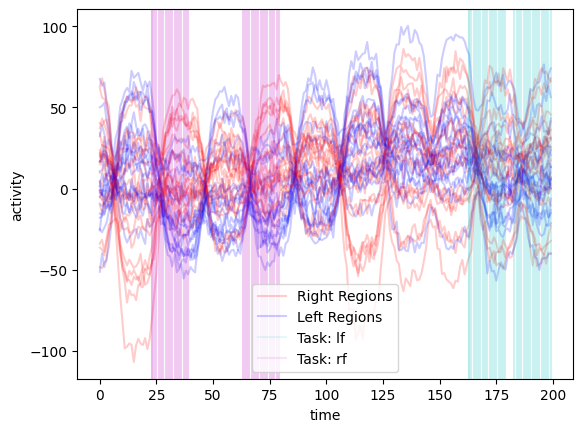



Above we plot, for one subject, the activity in every region, color-coded by hemisphere.
Notice that we should see (in a given subject) a good amount of correlation between region
from the same side, and likewise anticorrelation between regions in different hemispheres.
We programmed this behavior into the simulation (and a lot of noise), and so we do roughly see it.
At least, this should be the case when we have a task with laterality (and 4 of our 5 tasks do).


Now let's look at the same data, but put through a band-pass filter with standard cutoffs for fMRI:




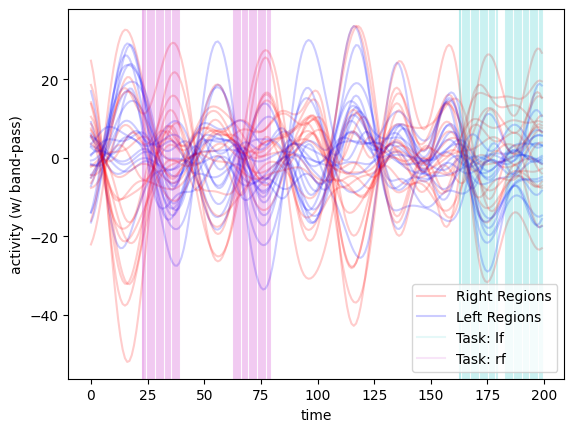

In [ ]:
# @title Time-Series by Region

my_subj = 3
my_run = 0

n_regions_to_plot = n_regions2
alphavalue = 0.2

# Let's plot BOLD value from two regions over the entire timecourse
right_region_timeseries = np.copy(BOLD_data[:,:n_regions_to_plot,my_subj,my_run])
left_region_timeseries = np.copy(BOLD_data[:,n_regions2:n_regions2+n_regions_to_plot,my_subj,my_run])

# Now let's grab all the frames of some stimulus condition so we can plot as vertical lines
cond1 = "lf" # which conditions?
cond2 = "rf"
st_fr1 = stim_frames(task_data, my_subj, my_run, cond1)
st_fr2 = stim_frames(task_data, my_subj, my_run, cond2)

# Plot
plt.plot(right_region_timeseries[:,0],color='r',alpha=alphavalue,label=f'Right Regions')
plt.plot(left_region_timeseries[:,0],color='b',alpha=alphavalue,label=f'Left Regions')
for r in np.arange(n_regions_to_plot)[1:]:
  plt.plot(right_region_timeseries[:,r],color='r',alpha=alphavalue)
  plt.plot(left_region_timeseries[:,r],color='b',alpha=alphavalue)
plt.axvline(x=st_fr1[0],color="c",alpha=0.1,label=f'Task: {cond1}')
for st in st_fr1:
  plt.axvline(x=st,color="c",alpha=0.2)
plt.axvline(x=st_fr2[0],color="m",alpha=0.1,label=f'Task: {cond2}')
for st in st_fr2:
  plt.axvline(x=st,color="m",alpha=0.2)
plt.xlabel('time')
plt.ylabel('activity')
plt.legend()
plt.show()

print("\n")
print("Above we plot, for one subject, the activity in every region, color-coded by hemisphere.")
print("Notice that we should see (in a given subject) a good amount of correlation between region")
print("from the same side, and likewise anticorrelation between regions in different hemispheres.")
print("We programmed this behavior into the simulation (and a lot of noise), and so we do roughly see it.")
print("At least, this should be the case when we have a task with laterality (and 4 of our 5 tasks do).")

print("\n")
print("Now let's look at the same data, but put through a band-pass filter with standard cutoffs for fMRI:")
print("\n")

for r in np.arange(n_regions_to_plot):
  right_region_timeseries[:,r] = band_pass(right_region_timeseries[:,r])
  left_region_timeseries[:,r] = band_pass(left_region_timeseries[:,r])

# Plot
plt.plot(right_region_timeseries[:,0],color='r',alpha=alphavalue,label=f'Right Regions')
plt.plot(left_region_timeseries[:,0],color='b',alpha=alphavalue,label=f'Left Regions')
for r in np.arange(n_regions_to_plot)[1:]:
  plt.plot(right_region_timeseries[:,r],color='r',alpha=alphavalue)
  plt.plot(left_region_timeseries[:,r],color='b',alpha=alphavalue)
plt.axvline(x=st_fr1[0],color="c",alpha=0.1,label=f'Task: {cond1}')
for st in st_fr1:
  plt.axvline(x=st,color="c",alpha=0.2)
plt.axvline(x=st_fr2[0],color="m",alpha=0.1,label=f'Task: {cond2}')
for st in st_fr2:
  plt.axvline(x=st,color="m",alpha=0.2)
plt.xlabel('time')
plt.ylabel('activity (w/ band-pass)')
plt.legend()
plt.show()

# Single Task Decoding

Here we write a single binary classifier (decoder). We'll run it on the simulated data (which is of a motor experiment), which had five conditions (right hand movement, left hand movement, right foot movement, left foot movement, tongue movement).

To simplify things, we pick both a target task and a distractor task, e.g. left-hand movement (target) vs right-hand movement (distractor). The decoder will be "trained" to predict when the target (vs the distractor) task is being done in each time block, based on the simulated activity in the regions in the somatomotor network. Chance performance is 50%.

Just as an example, the code below is set up to train the classifer to predict whether the right hand is being moved (target) vs the left hand. If a new task pair (e.g., right foot vs tongue) is specified, a new classifer will be trained, predicting whether the right hand is being moved in a given block.



Running decoding algorithm on simulated data:


Condition target: rh
Condition distractor: lh


Regularization type: l2
Regularization constant: 0.5
Number of k-folds: 8


Number of regions in network: 38
List of conditions in experiment:
['rh', 'lh']


Building training data...
dc_X_train shape: (80, 38)
dc_y_train shape: (80, 1)


Note: Depending on simulated data, there might be less than 100 rows (data samples).
As I've set it up, there are only 80. So, all the plots below show all the data, since
it's less than 100 rows.


... plotting first 100 rows of y training data.




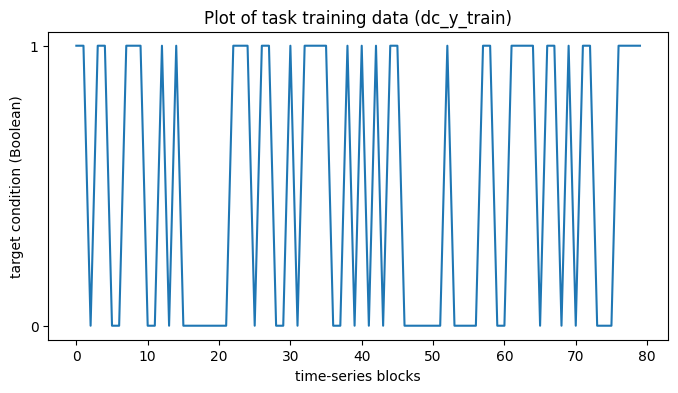



... plotting first 100 rows of X training data in heatmap.




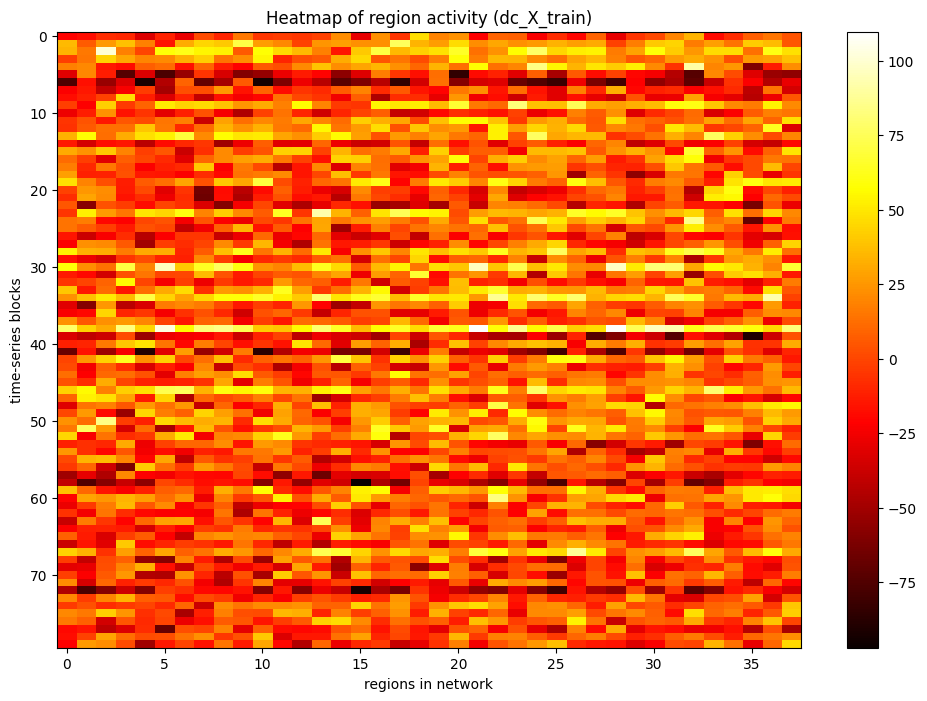



Rescaling X data for logistic regression.


Doing logistic regression on training data...


Defining model...
Fitting it to data
Predicting labels of training sample


Model coefficients: [[-0.73115304 -0.67829217  0.13166418  0.42460102 -0.36815756  0.05994668
   0.44966777 -0.22038715  0.30796974  0.13179279  0.01201244 -0.64703696
  -0.13338349  0.74189976  0.55714226 -0.74796433 -0.40985599  0.20984434
  -0.28394013 -0.91855582  0.40980537  0.22969438  0.0986188   0.17047024
   0.38984624  0.01334634  0.25022358  0.71211487  0.28190527  0.37495473
   0.13263397  0.43023733  0.35770775 -0.45789092 -0.25471709 -0.92382898
   0.26390612 -0.38737862]]


... plotting model coefficients.




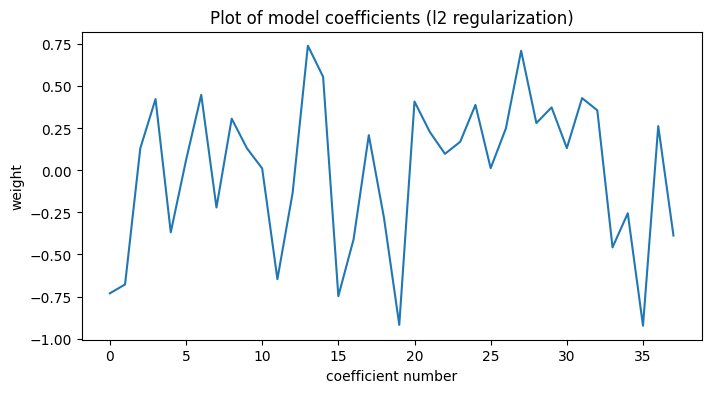



Computing accuracy...
Accuracy on the training data: 98.75%
Positive accuracy on the training data: 100.00%
Negative accuracy on the training data: 97.50%


... plotting first 100 rows of y training data w/ predictions.




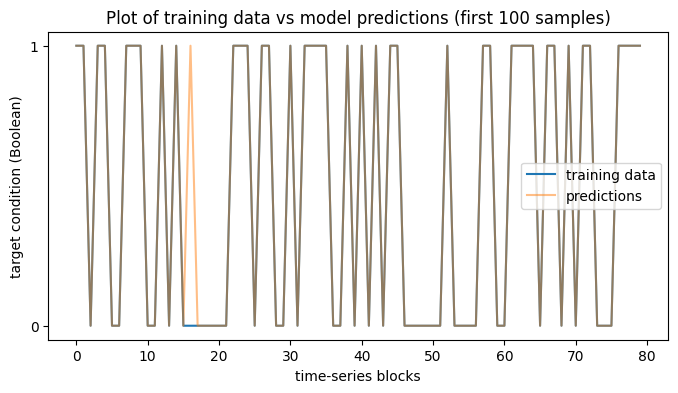



... plotting first 100 rows of y training data prediction success.




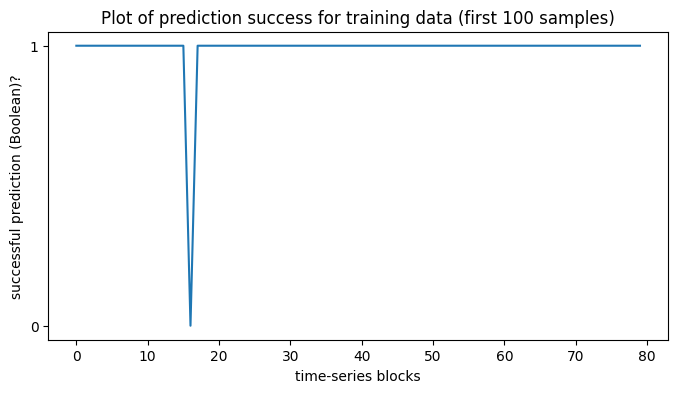



Testing for overfitting w/ cross-validation...


Accuracies: [0.8 0.9 0.8 0.5 0.7 1.  0.8 0.9]
Average test accuracy: 80.00%


... plotting overfitting (cross-validation) test results.




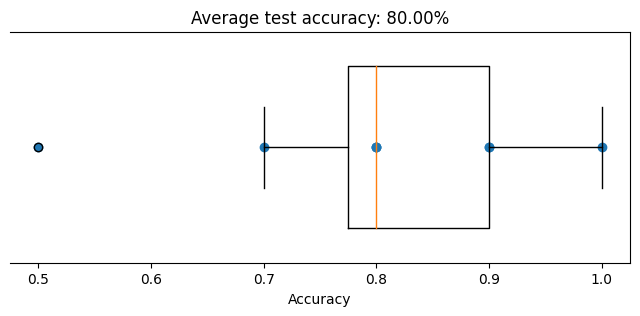



Building test data...
dc_X_test shape: (80, 38)
dc_y_test shape: (80, 1)


Rescaling X test data for predictions.




Computing accuracy on test data...
Accuracy on the test data: 96.25%
Positive accuracy on the test data: 97.50%
Negative accuracy on the test data: 95.00%


... plotting first 100 rows of y test data w/ predictions.




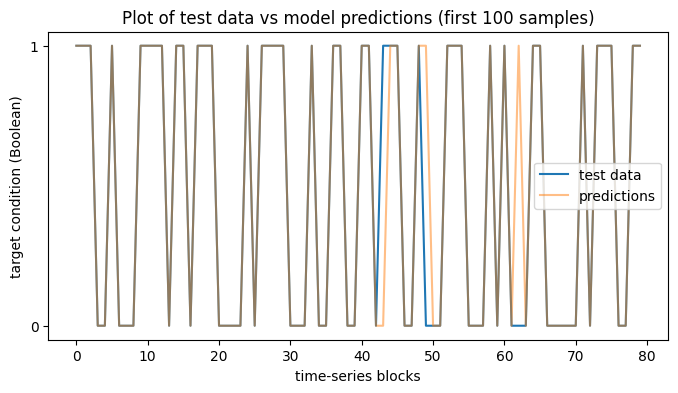



... plotting first 100 rows of y test data prediction success.




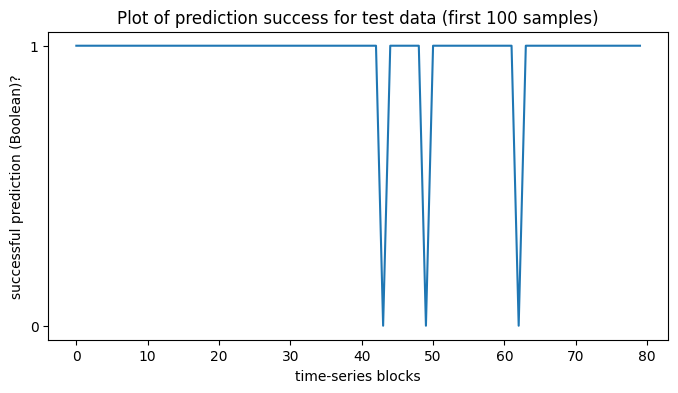

In [ ]:

# @title Decode single task from network w/ logistic regression

# Packages to import
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from numpy.core.numeric import ones_like
from google.colab import files

download_plots = False

# What should we plot?
plot_y_train = True # plot first n rows of dc_y_train w/ predictions??
plot_y_train_success = True # plot first n rows of training prediction success??
plot_y_train_only = True # plot first n rows of dc_y_train?
n_ytrain = 100
plot_y_test = True # plot first n rows of dc_y_train w/ predictions?
plot_y_test_success = True # plot first n rows of test data prediction success??
n_ytest = 100
plot_X_train = True # plot first n rows of dc_X_train in heat map?
n_Xtrain = 100
plot_overfitting_test = True # plot results from cross-validation?
plot_coef = True # plot coefficients from model?

# Settings for regularization / regression / cross-validation
Reg_C = 0.5 # Constant C for regularization in logistic regression
  # The smaller C, the bigger beta, and the more weights are suppressed. e.g., try 0.1, 1, and 10.
pen_type = "l2" # Penalty for regularization; options: None, "l1", "l2".
m_it = 10000
cv_k = 8 # folds in cross-validation
rescale_data = True # This is an option suggested by sklearn in error messages
                      # used as described by the package for training data;
                        # unsure if implemented right for test data.

# Randomize task order in training data to eliminate possibility docoder merely learns a temporal sequence?
randomize_task_order = True # Note that task order is already randomized in our simulated data, but this can't hurt.

# What are we decoding?
dc_cond_target = 'rh'
dc_cond_distractor = 'lh'

print("\n")
print(f'Running decoding algorithm on simulated data:')
print("\n")

print(f'Condition target: {dc_cond_target}')
print(f'Condition distractor: {dc_cond_distractor}')

print("\n")
print(f'Regularization type: {pen_type}')
print(f'Regularization constant: {Reg_C}')
print(f'Number of k-folds: {cv_k}')

# Break data into training and testing (for simplicity, by run number)
dc_run_training = 0 # 0 or 1
dc_run_test = 1 # 0 or 1

# Grab region names and numbers in network of interest
dc_network_region_names = list(somatomotor_regions.keys())
dc_network_region_numbers = list(somatomotor_regions.values())
dc_network_region_indexes = np.arange(len(dc_network_region_numbers))
dc_num_of_regions = len(dc_network_region_numbers)
print("\n")
print(f'Number of regions in network: {dc_num_of_regions}')

dc_condition_list = [dc_cond_target,dc_cond_distractor] # tasks
print(f'List of conditions in experiment:')
print(dc_condition_list)

# Want to build a training data array dc_X_train with columns as regions in network, rows as samples.
# The samples will be time-series blocks from participants.
# We'll divide the time series into blocks by experiment condition times.
# We'll construct this array one subject at a time

print("\n")
print(f'Building training data...')
def build_data(dc_run,dc_cond_target_,dc_cond_distractor_,dc_num_of_regions_):

  task_num_ = np.where(tasks == dc_cond_target_)[0]
  task_num_ = task_num_[0]

  distractor_num_ = np.where(tasks == dc_cond_distractor_)[0]
  distractor_num_ = distractor_num_[0]

  dc_X = np.empty((0, dc_num_of_regions))
  dc_y = np.empty((0, 1))
  dc_mask = np.empty((0, 1))

  for dc_subj in np.arange(n_subjects):

    # Divide time series into blocks by experiment condition times, build y
    time_blocks = []
    time_index = -1
    for task in np.arange(n_tasks*task_repeats_per_run):
      new_block = []
      for cue_step in np.arange(cue_length):
        time_index += 1
      for task_step in np.arange(task_length):
        time_index += 1
        new_block = new_block + [time_index]
      dc_yy = task_data[time_index,task_num_,dc_subj,dc_run]
      dc_y = np.vstack((dc_y,dc_yy)) # np.array([dc_yy]))
      dc_mm = np.maximum(task_data[time_index,task_num_,dc_subj,dc_run],
                     task_data[time_index,distractor_num_,dc_subj,dc_run])
      dc_mask = np.vstack((dc_mask,dc_mm))
      time_blocks.append(new_block)

    # Build X
    num_of_time_blocks = len(time_blocks)
    subj_dc_data = np.zeros((num_of_time_blocks, dc_num_of_regions_))
    for block_idx, block in enumerate(time_blocks):
      for region in dc_network_region_indexes:
        subj_dc_data[block_idx,region] = BOLD_data[block,region,dc_subj,dc_run].mean()

    dc_X = np.vstack((dc_X, subj_dc_data))

  dc_mask = np.where(dc_mask == 1)[0]
  dc_X = dc_X[dc_mask,:]
  dc_y = dc_y[dc_mask,:]

  if randomize_task_order:
    col_num = dc_y.shape[0]
    ran_idx = np.arange(col_num)
    np.random.shuffle(ran_idx)
    dc_X = dc_X[ran_idx,:]
    dc_y = dc_y[ran_idx,:]

  return dc_X, dc_y

dc_X_train, dc_y_train = build_data(dc_run_training,dc_cond_target,dc_cond_distractor,dc_num_of_regions)
print(f'dc_X_train shape: {dc_X_train.shape}')
print(f'dc_y_train shape: {dc_y_train.shape}')

print("\n")
print("Note: Depending on simulated data, there might be less than 100 rows (data samples).")
print("As I've set it up, there are only 80. So, all the plots below show all the data, since")
print("it's less than 100 rows.")

# plot first n rows of dc_y_train:
if plot_y_train_only:
  print("\n")
  print(f'... plotting first {n_ytrain} rows of y training data.')
  print("\n")
  plt.figure(figsize=(8, 4))
  plt.plot(dc_y_train[:n_ytrain,0])
  plt.xlabel('time-series blocks')
  plt.ylabel('target condition (Boolean)')
  plt.title('Plot of task training data (dc_y_train)')
  plt.yticks([0, 1], ['0', '1'])
  plt.savefig('y_train_data.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

# plot heat map of dc_X_train:
if plot_X_train:
  print("\n")
  print(f'... plotting first {n_Xtrain} rows of X training data in heatmap.')
  print("\n")
  plt.figure(figsize=(12, 8))
  plt.imshow(dc_X_train[:n_Xtrain,:], cmap='hot', interpolation='nearest', aspect='auto')
  plt.colorbar()
  plt.xlabel('regions in network')
  plt.ylabel('time-series blocks')
  plt.title('Heatmap of region activity (dc_X_train)')
  plt.savefig('x_train_heatmap.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

# This is an option suggested by sklearn in error messages
dc_X_train_scaled = 1
dc_X_test_scaled = 1
if rescale_data:
  print("\n")
  print("Rescaling X data for logistic regression.")
  print("\n")
  scaler = preprocessing.StandardScaler().fit(dc_X_train)
  scaler.mean_
  scaler.scale_
  dc_X_train_scaled = scaler.transform(dc_X_train)

# Logistic regression
print(f'Doing logistic regression on training data...')

print("\n")
print(f'Defining model...')
# Define the model
log_reg = 1
if pen_type == 'l1':
  log_reg = LogisticRegression(penalty=pen_type, C=Reg_C, solver="saga", max_iter=m_it)
else:
  log_reg = LogisticRegression(penalty=pen_type, C=Reg_C, max_iter=m_it)
print(f'Fitting it to data')
# Fit it to data
dc_y_train = dc_y_train.ravel()
if rescale_data:
  log_reg.fit(dc_X_train_scaled, dc_y_train)
else:
  log_reg.fit(dc_X_train, dc_y_train)
print(f'Predicting labels of training sample')
# Predict labels of sample
if rescale_data:
  dc_y_pred = log_reg.predict(dc_X_train_scaled)
else:
  dc_y_pred = log_reg.predict(dc_X_train)

print("\n")
print(f'Model coefficients: {log_reg.coef_}')

if plot_coef:
  print("\n")
  print("... plotting model coefficients.")
  print("\n")
  plt.figure(figsize=(8, 4))
  plt.plot(log_reg.coef_.squeeze())
  plt.xlabel('coefficient number')
  plt.ylabel('weight')
  plt.title(f'Plot of model coefficients ({pen_type} regularization)')
  plt.savefig('model_coefficients.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

print("\n")
print(f'Computing accuracy...')
# Compute accuracy
if rescale_data:
  train_accuracy = compute_accuracy(dc_X_train_scaled, dc_y_train, log_reg)
else:
  train_accuracy = compute_accuracy(dc_X_train, dc_y_train, log_reg)
print(f"Accuracy on the training data: {train_accuracy[0]:.2%}")
print(f"Positive accuracy on the training data: {train_accuracy[1]:.2%}")
print(f"Negative accuracy on the training data: {train_accuracy[2]:.2%}")

# plot first n rows of dc_y_train w/ predictions:
if plot_y_train:
  print("\n")
  print(f'... plotting first {n_ytrain} rows of y training data w/ predictions.')
  print("\n")
  y_pred = 1
  if rescale_data:
    y_pred = log_reg.predict(dc_X_train_scaled)
  else:
    y_pred = log_reg.predict(dc_X_train)
  plt.figure(figsize=(8, 4))
  plt.plot(dc_y_train[:n_ytrain], label="training data")
  plt.plot(y_pred[:n_ytrain], label="predictions", alpha=0.5)
  plt.xlabel('time-series blocks')
  plt.ylabel('target condition (Boolean)')
  plt.title(f'Plot of training data vs model predictions (first {n_ytrain} samples)')
  plt.yticks([0, 1], ['0', '1'])
  plt.legend()
  plt.savefig('y_train_data_predictions.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

# plot first n rows of prediction success:
if plot_y_train_success:
  print("\n")
  print(f'... plotting first {n_ytrain} rows of y training data prediction success.')
  print("\n")
  y_pred = 1
  if rescale_data:
    y_pred = log_reg.predict(dc_X_train_scaled)
  else:
    y_pred = log_reg.predict(dc_X_train)
  pred_succ = np.equal(y_pred, dc_y_train).astype(int)
  plt.figure(figsize=(8, 4))
  plt.plot(pred_succ[:n_ytrain])
  plt.xlabel('time-series blocks')
  plt.ylabel('successful prediction (Boolean)?')
  plt.title(f'Plot of prediction success for training data (first {n_ytrain} samples)')
  plt.yticks([0, 1], ['0', '1'])
  plt.savefig('y_train_pred_success.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

# Test for overfitting w/ cross-validation
print("\n")
print(f'Testing for overfitting w/ cross-validation...')
print("\n")
LRm = 1
if pen_type == 'l1':
  LRm = LogisticRegression(penalty=pen_type, C=Reg_C, solver="saga", max_iter=m_it)
else:
  LRm = LogisticRegression(penalty=pen_type, C=Reg_C, max_iter=m_it)
if rescale_data:
  accuracies = cross_val_score(LRm, dc_X_train_scaled, dc_y_train, cv=cv_k)  # k=8 cross validation
else:
  accuracies = cross_val_score(LRm, dc_X_train, dc_y_train, cv=cv_k)  # k=8 cross validation
print(f'Accuracies: {accuracies}')
print(f"Average test accuracy: {accuracies.mean():.2%}")
if plot_overfitting_test:
  print("\n")
  print("... plotting overfitting (cross-validation) test results.")
  print("\n")
  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(accuracies, vert=False, widths=.7)
  ax.scatter(accuracies, np.ones(8))
  ax.set(
    xlabel="Accuracy",
    yticks=[],
    title=f"Average test accuracy: {accuracies.mean():.2%}"
  )
  ax.spines["left"].set_visible(False)
  plt.savefig('over_fitting_results.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

# Now test on the test data
print("\n")
print(f'Building test data...')
dc_X_test, dc_y_test = build_data(dc_run_test,dc_cond_target,dc_cond_distractor,dc_num_of_regions)
print(f'dc_X_test shape: {dc_X_test.shape}')
print(f'dc_y_test shape: {dc_y_test.shape}')

if rescale_data:
  print("\n")
  print("Rescaling X test data for predictions.")
  print("\n")
  scaler = preprocessing.StandardScaler().fit(dc_X_test)
  scaler.mean_
  scaler.scale_
  dc_X_test_scaled = scaler.transform(dc_X_test)

print("\n")
print(f'Computing accuracy on test data...')
dc_y_test = dc_y_test.ravel()
# Compute accuracy
if rescale_data:
  test_accuracy = compute_accuracy(dc_X_test_scaled, dc_y_test, log_reg)
else:
  test_accuracy = compute_accuracy(dc_X_test, dc_y_test, log_reg)
print(f"Accuracy on the test data: {test_accuracy[0]:.2%}")
print(f"Positive accuracy on the test data: {test_accuracy[1]:.2%}")
print(f"Negative accuracy on the test data: {test_accuracy[2]:.2%}")

# plot first n rows of dc_y_test w/ predictions:
if plot_y_test:
  print("\n")
  print(f'... plotting first {n_ytrain} rows of y test data w/ predictions.')
  print("\n")
  y_pred = 1
  if rescale_data:
    y_pred = log_reg.predict(dc_X_test_scaled)
  else:
    y_pred = log_reg.predict(dc_X_test)
  plt.figure(figsize=(8, 4))
  plt.plot(dc_y_test[:n_ytest], label="test data")
  plt.plot(y_pred[:n_ytest], label="predictions", alpha=0.5)
  plt.xlabel('time-series blocks')
  plt.ylabel('target condition (Boolean)')
  plt.title(f'Plot of test data vs model predictions (first {n_ytest} samples)')
  plt.yticks([0, 1], ['0', '1'])
  plt.legend()
  plt.savefig('y_test_data_predictions.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

# plot first n rows of prediction success:
if plot_y_test_success:
  print("\n")
  print(f'... plotting first {n_ytrain} rows of y test data prediction success.')
  print("\n")
  y_pred = 1
  if rescale_data:
    y_pred = log_reg.predict(dc_X_test_scaled)
  else:
    y_pred = log_reg.predict(dc_X_test)
  pred_succ = np.equal(y_pred, dc_y_test).astype(int)
  plt.figure(figsize=(8, 4))
  plt.plot(pred_succ[:n_ytest])
  plt.xlabel('time-series blocks')
  plt.ylabel('successful prediction (Boolean)?')
  plt.title(f'Plot of prediction success for test data (first {n_ytest} samples)')
  plt.yticks([0, 1], ['0', '1'])
  plt.savefig('y_test_pred_success.png')
  #plt.close() # comment out to show in CoLab instead of just downloading
  plt.show() # uncomment to show in CoLab instead of just downloading

if download_plots:
  files.download('y_test_pred_success.png')
  files.download('y_test_data_predictions.png')
  files.download('over_fitting_results.png')
  files.download('y_train_pred_success.png')
  files.download('y_train_data_predictions.png')
  files.download('model_coefficients.png')
  files.download('y_train_data.png')
  files.download('x_train_heatmap.png')
